In [ ]:
%load_ext autoreload
%autoreload 2
!pip install kornia==0.6.10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!pip install kornia_moons

In [ ]:
!pip install pycolmap

In [ ]:
import cv2
import torch
from kornia_moons.feature import *
import pycolmap
import os
import h5py
import kornia as K
import kornia.feature as KF
from fastprogress import progress_bar
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import defaultdict
import numpy as np

def load_torch_image(fname, device=torch.device('cuda')):
    img = K.image_to_tensor(cv2.imread(fname), False).float() /255.
    img = K.color.bgr_to_rgb(img.to(device))
    return img

device = torch.device('cuda')

## Download example data

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


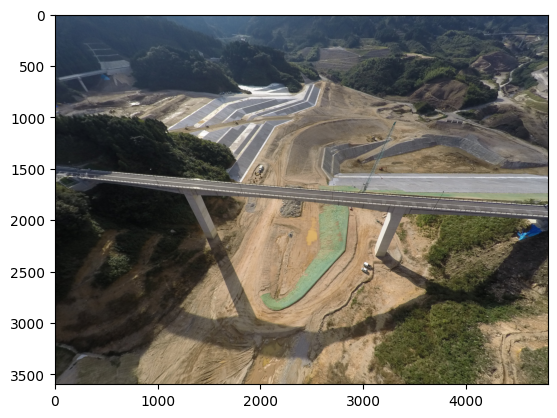

In [ ]:
dirname = os.path.join('/content/drive/MyDrive/3 D reconstruction test/dirname')
img_fnames = [os.path.join(dirname, x) for x in os.listdir(dirname) if '.jpg' in x]
plt.imshow(cv2.cvtColor(cv2.imread(img_fnames[0]), cv2.COLOR_BGR2RGB))

## LoFTR Matching

In [ ]:
def get_unique_idxs(A, dim=1):
    # https://stackoverflow.com/questions/72001505/how-to-get-unique-elements-and-their-firstly-appeared-indices-of-a-pytorch-tenso
    unique, idx, counts = torch.unique(A, dim=dim, sorted=True, return_inverse=True, return_counts=True)
    _, ind_sorted = torch.sort(idx, stable=True)
    cum_sum = counts.cumsum(0)
    cum_sum = torch.cat((torch.tensor([0],device=cum_sum.device), cum_sum[:-1]))
    first_indicies = ind_sorted[cum_sum]
    return first_indicies

def match_features(img_fnames,
                   index_pairs,
                   feature_dir = '.featureout_loftr',
                   device=torch.device('cuda'),
                   min_matches=30, resize_to_ = (1280, 960)):
    matcher = KF.LoFTR(pretrained='outdoor').to(device).eval()
    # First we do pairwise matching, and then extract "keypoints" from loftr matches

    with h5py.File(f'{feature_dir}/matches_loftr.h5', mode='w') as f_match:
        for pair_idx in progress_bar(index_pairs):
            idx1, idx2 = pair_idx
            fname1, fname2 = img_fnames[idx1], img_fnames[idx2]
            key1, key2 = fname1.split('/')[-1], fname2.split('/')[-1]
            # Load img1
            timg1 = K.color.rgb_to_grayscale(load_torch_image(fname1, device=device))
            H1, W1 = timg1.shape[2:]
            if H1 < W1:
                resize_to = resize_to_[1], resize_to_[0]
            else:
                resize_to = resize_to_
            timg_resized1 = K.geometry.resize(timg1, resize_to, antialias=True)
            h1, w1 = timg_resized1.shape[2:]

            # Load img2
            timg2 = K.color.rgb_to_grayscale(load_torch_image(fname2, device=device))
            H2, W2 = timg2.shape[2:]
            if H2 < W2:
                resize_to2 = resize_to[1], resize_to[0]
            else:
                resize_to2 = resize_to_
            timg_resized2 = K.geometry.resize(timg2, resize_to2, antialias=True)
            h2, w2 = timg_resized2.shape[2:]
            with torch.inference_mode():
                input_dict = {"image0": timg_resized1,"image1": timg_resized2}
                correspondences = matcher(input_dict)
            mkpts0 = correspondences['keypoints0'].cpu().numpy()
            mkpts1 = correspondences['keypoints1'].cpu().numpy()

            mkpts0[:,0] *= float(W1) / float(w1)
            mkpts0[:,1] *= float(H1) / float(h1)

            mkpts1[:,0] *= float(W2) / float(w2)
            mkpts1[:,1] *= float(H2) / float(h2)

            n_matches = len(mkpts1)
            group  = f_match.require_group(key1)
            if n_matches >= min_matches:
                 group.create_dataset(key2, data=np.concatenate([mkpts0, mkpts1], axis=1))
    # Let's find unique loftr pixels and group them together
    kpts = defaultdict(list)
    match_indexes = defaultdict(dict)
    total_kpts=defaultdict(int)
    with h5py.File(f'{feature_dir}/matches_loftr.h5', mode='r') as f_match:
        for k1 in f_match.keys():
            group  = f_match[k1]
            for k2 in group.keys():
                matches = group[k2][...]
                total_kpts[k1]
                kpts[k1].append(matches[:, :2])
                kpts[k2].append(matches[:, 2:])
                current_match = torch.arange(len(matches)).reshape(-1, 1).repeat(1, 2)
                current_match[:, 0]+=total_kpts[k1]
                current_match[:, 1]+=total_kpts[k2]
                total_kpts[k1]+=len(matches)
                total_kpts[k2]+=len(matches)
                match_indexes[k1][k2]=current_match
    for k in kpts.keys():
        kpts[k] = np.round(np.concatenate(kpts[k], axis=0))
    unique_kpts = {}
    unique_match_idxs = {}
    out_match = defaultdict(dict)
    for k in kpts.keys():
        uniq_kps, uniq_reverse_idxs = torch.unique(torch.from_numpy(kpts[k]),dim=0, return_inverse=True)
        unique_match_idxs[k] = uniq_reverse_idxs
        unique_kpts[k] = uniq_kps.numpy()
    for k1, group in match_indexes.items():
        for k2, m in group.items():
            m2 = deepcopy(m)
            m2[:,0] = unique_match_idxs[k1][m2[:,0]]
            m2[:,1] = unique_match_idxs[k2][m2[:,1]]
            mkpts = np.concatenate([unique_kpts[k1][ m2[:,0]],
                                    unique_kpts[k2][  m2[:,1]],
                                   ],
                                   axis=1)
            unique_idxs_current = get_unique_idxs(torch.from_numpy(mkpts), dim=0)
            m2_semiclean = m2[unique_idxs_current]
            unique_idxs_current1 = get_unique_idxs(m2_semiclean[:, 0], dim=0)
            m2_semiclean = m2_semiclean[unique_idxs_current1]
            unique_idxs_current2 = get_unique_idxs(m2_semiclean[:, 1], dim=0)
            m2_semiclean2 = m2_semiclean[unique_idxs_current2]
            out_match[k1][k2] = m2_semiclean2.numpy()
    with h5py.File(f'{feature_dir}/keypoints.h5', mode='w') as f_kp:
        for k, kpts1 in unique_kpts.items():
            f_kp[k] = kpts1

    with h5py.File(f'{feature_dir}/matches.h5', mode='w') as f_match:
        for k1, gr in out_match.items():
            group  = f_match.require_group(k1)
            for k2, match in gr.items():
                group[k2] = match
    return



In [ ]:
# matching all to all
index_pairs = []
for i in range(len(img_fnames)):
    for j in range(i+1, len(img_fnames)):
        index_pairs.append((i,j))


In [ ]:
import os

# Create the directory if it doesn't exist
if not os.path.exists('.featureout_loftr'):
    os.makedirs('.featureout_loftr')

feature_dir = '.featureout_loftr'

dev=torch.device('mps')
dev=torch.device('cuda')

In [ ]:
match_features(img_fnames, index_pairs, feature_dir = feature_dir, device=dev)

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to /root/.cache/torch/hub/checkpoints/loftr_outdoor.ckpt
100%|██████████| 44.2M/44.2M [00:02<00:00, 17.7MB/s]


In [ ]:
%cd .featureout_loftr

In [ ]:
!ls -a

In [ ]:
from google.colab import files


# Télécharger l'archive ZIP
files.download('matches_loftr.h5')
files.download('keypoints.h5')
files.download('matches.h5')